# Рекомендация тарифов

## Открытие и изучение файла

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Для построения модели предоставлены данные за месяц, которые состоят из 5 столбцов и 3214 строк. 

Пропуски не выявлены.

Каких то числовых аномалий не выявлено

## Проверка на дубликаты и изменение типов данных ##

Проверю на наличие полных дубликатов, а также изменю тип данных в столбцах 'calls' и 'messages' на int (так как количество СМС и звонков не может быть дробным)

In [6]:
df.duplicated().sum()

0

In [7]:
df['calls'] = df['calls'].astype('int')

In [8]:
df['messages'] = df['messages'].astype('int')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null int64
minutes     3214 non-null float64
messages    3214 non-null int64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [10]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


Полные дубликаты отсутствуют, замена типа данных произведена успешно

## Выделение цели и признаков ##

Сразу выделю целевой признак (тариф ультра или нет) и сохраню в переменную target, остальные признаки сохраню в переменную features

In [11]:
features = df.drop(['is_ultra'], axis =1)

In [12]:
target = df['is_ultra']

## Разбивка данных на выборки

Разделю данные на 3 выборки: обучающую (60%), тестовую (20%), валидационную (20%). 

Создам переменные: train_features и train_target, test_features и test_target, valid_features и valid_target.

Для этого сначала разобью данные на обучающую выборку (60%) и тестовую выборку (40%), затем тестовую выборку разделю пополам на тестовую и валидационные выборки 

In [13]:
train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.4, 
                                                                            random_state = 12345)

In [14]:
test_features, valid_features, test_target, valid_target = train_test_split(test_features, 
                                                                            test_target, 
                                                                            test_size = 0.5, 
                                                                            random_state = 12345)

Проверю размеры полученных таблиц 

In [15]:
train_features.shape

(1928, 4)

In [16]:
train_target.shape

(1928,)

In [17]:
test_features.shape

(643, 4)

In [18]:
test_target.shape

(643,)

In [19]:
valid_features.shape

(643, 4)

In [20]:
valid_target.shape

(643,)

Разбивка данных произошла удачно:

- в обучающей выборке 1928 объектов с данными;

- в тестовой и валидационной выборках по 643 объекта с данными

## Исследование моделей ##

Исследую 3 популярных модели обучения для задачи классификации: 
- Решающее дерево (Decision Tree), 

- Случайный лес (Random Forest),

- Логистическая регрессия (Logistic Regression). 

Затем выведу на печать показатели значения accuracy наилучшей модели на валидационной выборке. 

Гиперпараметр Глубина дерева укажу от 1 до 5 (указание глубины дерева до 4-х  может повлечь недообучение, слишком большая глубина - переообучение)

### Решающее дерево (Decision Tree) ###

Для определения лучшего результата работы модели "Решающее дерево", сделаю цикл, который переберет гиперпараметр глубины дерева от 1 до 5, обучу модель на тренировочной выборке и проверю метрику качества accuracy на валидационной выборке.

In [21]:
best_model_DT = None
best_result_DT = 0 
best_depth_DT = 0
for depth in range(1,6):
    model_DT = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model_DT.fit(train_features, train_target)
    result_DT = model_DT.score(valid_features, valid_target)
    if result_DT > best_result_DT:
        best_model_DT = model_DT
        best_result_DT = result_DT
        best_depth_DT = depth

In [22]:
print('Accuracy налучшей модели на валидационной выборке:', best_result_DT, 'при глубине дерева:', best_depth_DT)

Accuracy налучшей модели на валидационной выборке: 0.7838258164852255 при глубине дерева: 5


### Случайный лес (Random Forest) ###

Для определения лучшего результата работы модели "Случайный лес", сделаю цикл, который переберет гиперпараметр количества деревьев от 10 до 50 с глубиной дерева от 1 до 5, обучу модель на тренировочной выборке и проверю метрику качества accuracy на валидационной выборке.

In [23]:
best_model_RF = None
best_result_RF = 0
best_est_RF = 0
best_depth_RF = 0
for est in range(10, 51):
    for depth in range(1, 6):
        model_RF = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model_RF.fit(train_features, train_target)
        result_RF = model_RF.score(valid_features, valid_target)
        if result_RF > best_result_RF:
            best_model_RF = model_RF
            best_result_RF = result_RF
            best_est_RF = est
            best_depth_RF = depth

In [24]:
print('Accuracy налучшей модели на валидационной выборке:', best_result_RF,
      'с количеством деревьев:', best_est_RF, ', при глубине дерева:', best_depth_RF)

Accuracy налучшей модели на валидационной выборке: 0.7947122861586314 с количеством деревьев: 16 , при глубине дерева: 5


### Логистическая регрессия (Logistic Regression) ###

Для определения лучшего результата работы модели "Логистическая регрессия", обучу модель на тренировочной выборке и проверю метрику качества accuracy на валидационной выборке.

In [25]:
model_LR = LogisticRegression(random_state = 12345, solver = 'lbfgs', max_iter = 500)
model_LR.fit(train_features, train_target)
result_LR = model_LR.score(valid_features, valid_target)

In [26]:
print('Accuracy налучшей модели на валидационной выборке:', result_LR)

Accuracy налучшей модели на валидационной выборке: 0.6842923794712286


### Вывод ###

In [27]:
print('Accuracy налучшей модели на валидационной выборке:')
print('')
print('Решающее дерево:', best_result_DT, 'при глубине дерева:', best_depth_DT)
print('Случайный лес:', best_result_RF, 'с количеством деревьев:', best_est_RF, ', при глубине дерева:', best_depth_RF)
print('Логистическая регрессия:', result_LR)

Accuracy налучшей модели на валидационной выборке:

Решающее дерево: 0.7838258164852255 при глубине дерева: 5
Случайный лес: 0.7947122861586314 с количеством деревьев: 16 , при глубине дерева: 5
Логистическая регрессия: 0.6842923794712286


Наибольшую точность согласно метрике качества Accuracy (количество правильных ответов) показывает модель **Случайный лес (Random Forest)**. Однако это самый долгий по времени исполнения алгоритм

## Проверка моделей на тестовой выборке

Посчитаю метрику Accuracy для разных моделей на тестовой выборке

In [28]:
result_DT_test = model_DT.score(test_features, test_target)

In [29]:
print('Accuracy налучшей модели "Решающее дерево" на тестовой выборке:', result_DT_test)

Accuracy налучшей модели "Решающее дерево" на тестовой выборке: 0.7791601866251944


In [30]:
result_RF_test = model_RF.score(test_features, test_target)

In [31]:
print('Accuracy налучшей модели "Случайный лес" на тестовой выборке:', result_RF_test)

Accuracy налучшей модели "Случайный лес" на тестовой выборке: 0.7931570762052877


In [32]:
result_LR_test = model_LR.score(test_features, test_target)

In [33]:
print('Accuracy налучшей модели "Логистическая регрессия" на тестовой выборке:', result_LR_test)

Accuracy налучшей модели "Логистическая регрессия" на тестовой выборке: 0.7107309486780715


**Вывод**

По результатам проверки работы моделей на тестовой выборке большую точность также показала модель **Случайный лес (Random Forest)**.

Доля правильных ответов в модели Логистическая регрессия (Logistic Regression) на тестовой выборке выше, чем на валидационной выборке 

## Проверка моделей на адекватность

Для проверки модели на адекватность использую метод DummyClassifier. 

С помощью цикла посчитаю метрику accuracy на тестовой выборке для следующих стратегий метода DummyClassifier: 'most_frequent', 'stratified', 'uniform'.

Я не буду использовать стратегию constant, так как не проставляла постоянных меток в данных

In [34]:
strategies = ['most_frequent', 'stratified', 'uniform']
result_dummy_test = []
for s in strategies:
    model_dummy = DummyClassifier(strategy = s, random_state = 12345)
    model_dummy.fit(train_features, train_target)
    result_dummy = model_dummy.score(test_features, test_target)
    result_dummy_test.append(result_dummy)

In [35]:
result_dummy_test

[0.7060653188180405, 0.5925349922239502, 0.5038880248833593]

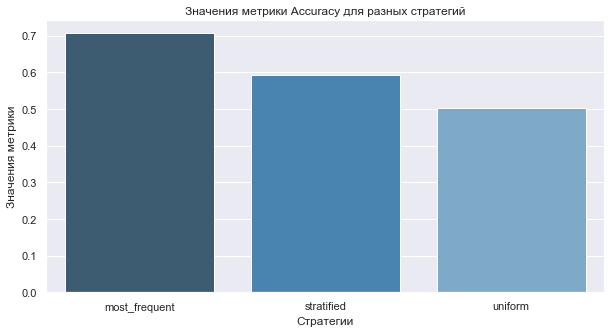

In [36]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
ax = sns.barplot(strategies,result_dummy_test, palette="Blues_d")
ax.set(xlabel = 'Стратегии', ylabel = 'Значения метрики')
plt.title('Значения метрики Accuracy для разных стратегий',fontsize=12)
plt.show()

**Вывод**

Сравнивая оценки метрики Accuracy для модели  Случайный лес (Random Forest) с фиктивным классификатором DummyClassifier, я пришла  к выводу, что модель работает корректно - оценки фиктивного классификатора ниже, чем оценки модели.